<a href="https://colab.research.google.com/github/nana881023/Financial_Big_Data_Analysis/blob/main/Week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 1. 安裝與環境設置

In [ ]:
# 安裝套件
%%capture
!pip install datasets yfinance transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

- 數據預處理類

In [ ]:
class FinancialDataProcessor:
  def __init__(self, stock_symbol='AAPL', start_date='2019-01-01', end_date='2024-01-01'):
    self.stock_symbol = stock_symbol
    self.start_date = start_date
    self.end_date = end_date

  def load_stock_data(self):
    # 使用 yfinance 下載股票數據
    stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
    stock_data = stock_data.reset_index()
    return stock_data

  def load_sentiment_data(self):
    # 直接載入 Financial PhraseBank 數據集
    dataset = load_dataset("takala/financial_phrasebank", name="sentences_75agree")
    # 將數據轉換為 pandas DataFrame
    sentiment_df = pd.DataFrame({
        'text': dataset['train']['sentence'],
        'sentiment': dataset['train']['label']
    })
    return sentiment_df

  def prepare_data(self):
    # 獲取股票數據
    stock_data = self.load_stock_data()
    sentiment_data = self.load_sentiment_data()

    # 準備股票特徵
    price_features = ['Open', 'High', 'Low', 'Close', 'Volume']

    # 標準化價格數據
    scaler = StandardScaler()
    stock_data[price_features] = scaler.fit_transform(stock_data[price_features])

    # 標準化情緒分數 (0, 1, 2) -> (-1, 0, 1)
    sentiment_data['sentiment'] = (sentiment_data['sentiment'] - 1)

    # 為每個交易日隨機分配情緒數據
    np.random.seed(42)
    selected_sentiments = sentiment_data['sentiment'].sample(
        n=len(stock_data),
        replace=True
    ).values

    # 準備特徵和標籤
    X_price = stock_data[price_features].values[:-1]  # 除去最後一天
    X_sentiment = selected_sentiments[:-1].reshape(-1, 1)  # 除去最後一天

    # 計算明天的漲跌作為標籤 (1: 上漲, 0: 下跌)
    y = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int).values[:-1]

    return X_price, X_sentiment, y


- 自定義數據集類

In [ ]:
class FinancialDataset(Dataset):
  def __init__(self, price_data, sentiment_data, labels):
    self.price_data = torch.FloatTensor(price_data)
    self.sentiment_data = torch.FloatTensor(sentiment_data)
    # 確保標籤是一維張量
    self.labels = torch.LongTensor(labels).squeeze()

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
        'price': self.price_data[idx],
        'sentiment': self.sentiment_data[idx],
        'label': self.labels[idx]
    }

- 早期融合模型定義

In [ ]:
class EarlyFusionModel(nn.Module):
  def __init__(self, price_dim, sentiment_dim):
    super(EarlyFusionModel, self).__init__()

    # 融合維度
    total_dim = price_dim + sentiment_dim

    # 定義網絡層
    self.fusion_network = nn.Sequential(
      nn.Linear(total_dim, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),
      nn.Dropout(0.3),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.BatchNorm1d(32),
      nn.Dropout(0.2),
      nn.Linear(32, 2)
    )

  def forward(self, price_data, sentiment_data):
    # 早期融合: 直接拼接特徵
    combined_features = torch.cat((price_data, sentiment_data), dim=1)
    output = self.fusion_network(combined_features)
    return output

- 訓練函數

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Using device: {device}")

  model = model.to(device)
  best_val_acc = 0

  for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
      price_data = batch['price'].to(device)
      sentiment_data = batch['sentiment'].to(device)
      labels = batch['label'].to(device)

      # 確保數據維度正確
      if len(labels.shape) > 1:
          labels = labels.squeeze()

      optimizer.zero_grad()
      outputs = model(price_data, sentiment_data)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      train_total += labels.size(0)
      train_correct += predicted.eq(labels).sum().item()

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for batch in val_loader:
        price_data = batch['price'].to(device)
        sentiment_data = batch['sentiment'].to(device)
        labels = batch['label'].to(device)

        # 確保數據維度正確
        if len(labels.shape) > 1:
            labels = labels.squeeze()

        outputs = model(price_data, sentiment_data)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

    # 計算指標
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    # 更新最佳驗證準確率
    if val_acc > best_val_acc:
      best_val_acc = val_acc

    # 打印訓練信息
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Best Val Acc: {best_val_acc:.2f}%')
    print('--------------------')

In [ ]:
# 添加評估函數
def evaluate_model(model, test_loader, criterion):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  test_loss = 0
  test_correct = 0
  test_total = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for batch in test_loader:
      price_data = batch['price'].to(device)
      sentiment_data = batch['sentiment'].to(device)
      labels = batch['label'].to(device)

      if len(labels.shape) > 1:
        labels = labels.squeeze()

      outputs = model(price_data, sentiment_data)
      loss = criterion(outputs, labels)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      test_total += labels.size(0)
      test_correct += predicted.eq(labels).sum().item()

      # 收集預測結果
      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # 計算整體指標
  test_acc = 100. * test_correct / test_total
  test_loss = test_loss / len(test_loader)

  print("\n測試集評估結果:")
  print(f'Test Loss: {test_loss:.4f}')
  print(f'Test Accuracy: {test_acc:.2f}%')

  # 計算漲跌預測的詳細統計
  predictions = np.array(all_predictions)
  true_labels = np.array(all_labels)

  # 計算各類指標
  true_pos = np.sum((predictions == 1) & (true_labels == 1))
  true_neg = np.sum((predictions == 0) & (true_labels == 0))
  false_pos = np.sum((predictions == 1) & (true_labels == 0))
  false_neg = np.sum((predictions == 0) & (true_labels == 1))

  print("\n詳細預測統計:")
  print(f"正確預測上漲次數: {true_pos}")
  print(f"正確預測下跌次數: {true_neg}")
  print(f"錯誤預測上漲次數: {false_pos}")
  print(f"錯誤預測下跌次數: {false_neg}")
  print(f"\n上漲預測準確率: {100 * true_pos/(true_pos + false_pos):.2f}%")
  print(f"下跌預測準確率: {100 * true_neg/(true_neg + false_neg):.2f}%")

  return test_acc, predictions, true_labels

In [ ]:
# 添加必要的導入
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# 添加視覺化函數
def plot_prediction_results(predictions, true_labels, test_loader):
  plt.figure(figsize=(15, 8))

  # Plot confusion matrix
  plt.subplot(1, 2, 1)
  cm = confusion_matrix(true_labels, predictions)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  # Plot prediction comparison
  plt.subplot(1, 2, 2)
  plt.plot(true_labels, label='Actual', color='blue', alpha=0.5)
  plt.plot(predictions, label='Predicted', color='red', alpha=0.5)
  plt.title('Prediction Results')
  plt.xlabel('Test Samples')
  plt.ylabel('Stock Movement (0:Down, 1:Up)')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

  # Print statistics
  accuracy = (predictions == true_labels).mean()
  print(f"\nOverall Accuracy: {accuracy:.4f}")

  # Calculate accuracy for up and down predictions
  up_mask = true_labels == 1
  down_mask = true_labels == 0

  up_accuracy = (predictions[up_mask] == true_labels[up_mask]).mean()
  down_accuracy = (predictions[down_mask] == true_labels[down_mask]).mean()

  print(f"Upward Movement Prediction Accuracy: {up_accuracy:.4f}")
  print(f"Downward Movement Prediction Accuracy: {down_accuracy:.4f}")

  # Calculate prediction distribution
  print("\nPrediction Distribution:")
  pred_dist = pd.Series(predictions).value_counts(normalize=True)
  print(pred_dist)

  print("\nActual Distribution:")
  true_dist = pd.Series(true_labels).value_counts(normalize=True)
  print(true_dist)

- 主程式

In [ ]:
print("開始載入數據...")
processor = FinancialDataProcessor(stock_symbol='AAPL')
X_price, X_sentiment, y = processor.prepare_data()

# 確保標籤是一維的
y = y.reshape(-1)

X_price, X_sentiment, y

開始載入數據...


[*********************100%***********************]  1 of 1 completed


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for takala/financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/takala/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

(array([[-1.81061663, -1.80331629, -1.80242458, -1.79645405,  0.88549926],
        [-1.86927989, -1.87327911, -1.86878667, -1.88100776,  5.01347392],
        [-1.86632252, -1.85819954, -1.85901954, -1.84837963,  2.52591901],
        ...,
        [ 1.52071358,  1.48280365,  1.54601337,  1.50549533, -1.3818444 ],
        [ 1.49662465,  1.47449126,  1.50824707,  1.50764526, -1.01735654],
        [ 1.53211282,  1.49921543,  1.55339288,  1.51689097, -1.28428584]]),
 array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]]),
 array([0, 1, 0, ..., 1, 1, 0]))

In [ ]:
print("數據載入完成，開始準備訓練...")
print(f"數據形狀: X_price: {X_price.shape}, X_sentiment: {X_sentiment.shape}, y: {y.shape}")

# 第二個區塊：數據分割
X_price_train, X_price_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(
    X_price, X_sentiment, y, test_size=0.2, random_state=42
)


數據載入完成，開始準備訓練...
數據形狀: X_price: (1257, 5), X_sentiment: (1257, 1), y: (1257,)


In [ ]:
print("創建數據加載器...")
train_dataset = FinancialDataset(X_price_train, X_sentiment_train, y_train)
test_dataset = FinancialDataset(X_price_test, X_sentiment_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

創建數據加載器...


In [ ]:
print("初始化模型...")
model = EarlyFusionModel(price_dim=5, sentiment_dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

optimizer

初始化模型...


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)

In [ ]:
print("開始訓練...")
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30)


開始訓練...
Using device: cpu
Epoch [1/30]
Train Loss: 0.7654 | Train Acc: 47.76%
Val Loss: 0.7010 | Val Acc: 53.17%
Best Val Acc: 53.17%
--------------------
Epoch [2/30]
Train Loss: 0.7467 | Train Acc: 50.45%
Val Loss: 0.6966 | Val Acc: 52.78%
Best Val Acc: 53.17%
--------------------
Epoch [3/30]
Train Loss: 0.7148 | Train Acc: 49.65%
Val Loss: 0.6985 | Val Acc: 51.59%
Best Val Acc: 53.17%
--------------------
Epoch [4/30]
Train Loss: 0.7007 | Train Acc: 52.44%
Val Loss: 0.6958 | Val Acc: 50.40%
Best Val Acc: 53.17%
--------------------
Epoch [5/30]
Train Loss: 0.7075 | Train Acc: 50.35%
Val Loss: 0.6924 | Val Acc: 50.00%
Best Val Acc: 53.17%
--------------------
Epoch [6/30]
Train Loss: 0.6969 | Train Acc: 52.74%
Val Loss: 0.6921 | Val Acc: 52.38%
Best Val Acc: 53.17%
--------------------
Epoch [7/30]
Train Loss: 0.7071 | Train Acc: 51.14%
Val Loss: 0.6993 | Val Acc: 51.59%
Best Val Acc: 53.17%
--------------------
Epoch [8/30]
Train Loss: 0.6959 | Train Acc: 52.44%
Val Loss: 0.6999 | 

In [ ]:
# 第六個區塊：模型評估
print("\n開始在測試集上評估模型...")
test_acc, predictions, true_labels = evaluate_model(model, test_loader, criterion)

# 計算並顯示總體準確率
total_accuracy = np.sum(np.abs(predictions - true_labels) < 0.05) / len(predictions)  # 允許5%的誤差
print(f"\n總體準確率 (誤差<5%): {total_accuracy:.4f}")

# 計算其他評估指標
mse = np.mean((predictions - true_labels) ** 2)
mae = np.mean(np.abs(predictions - true_labels))
rmse = np.sqrt(mse)

print(f"均方誤差 (MSE): {mse:.4f}")
print(f"平均絕對誤差 (MAE): {mae:.4f}")
print(f"均方根誤差 (RMSE): {rmse:.4f}")

# 計算方向準確率（預測趨勢的正確比例）
direction_correct = np.sum(np.sign(np.diff(predictions)) == np.sign(np.diff(true_labels))) / (len(predictions) - 1)
print(f"方向預測準確率: {direction_correct:.4f}")


開始在測試集上評估模型...

測試集評估結果:
Test Loss: 0.6930
Test Accuracy: 53.17%

詳細預測統計:
正確預測上漲次數: 85
正確預測下跌次數: 49
錯誤預測上漲次數: 63
錯誤預測下跌次數: 55

上漲預測準確率: 57.43%
下跌預測準確率: 47.12%

總體準確率 (誤差<5%): 0.5317
均方誤差 (MSE): 0.4683
平均絕對誤差 (MAE): 0.4683
均方根誤差 (RMSE): 0.6843
方向預測準確率: 0.3984



繪製預測結果...


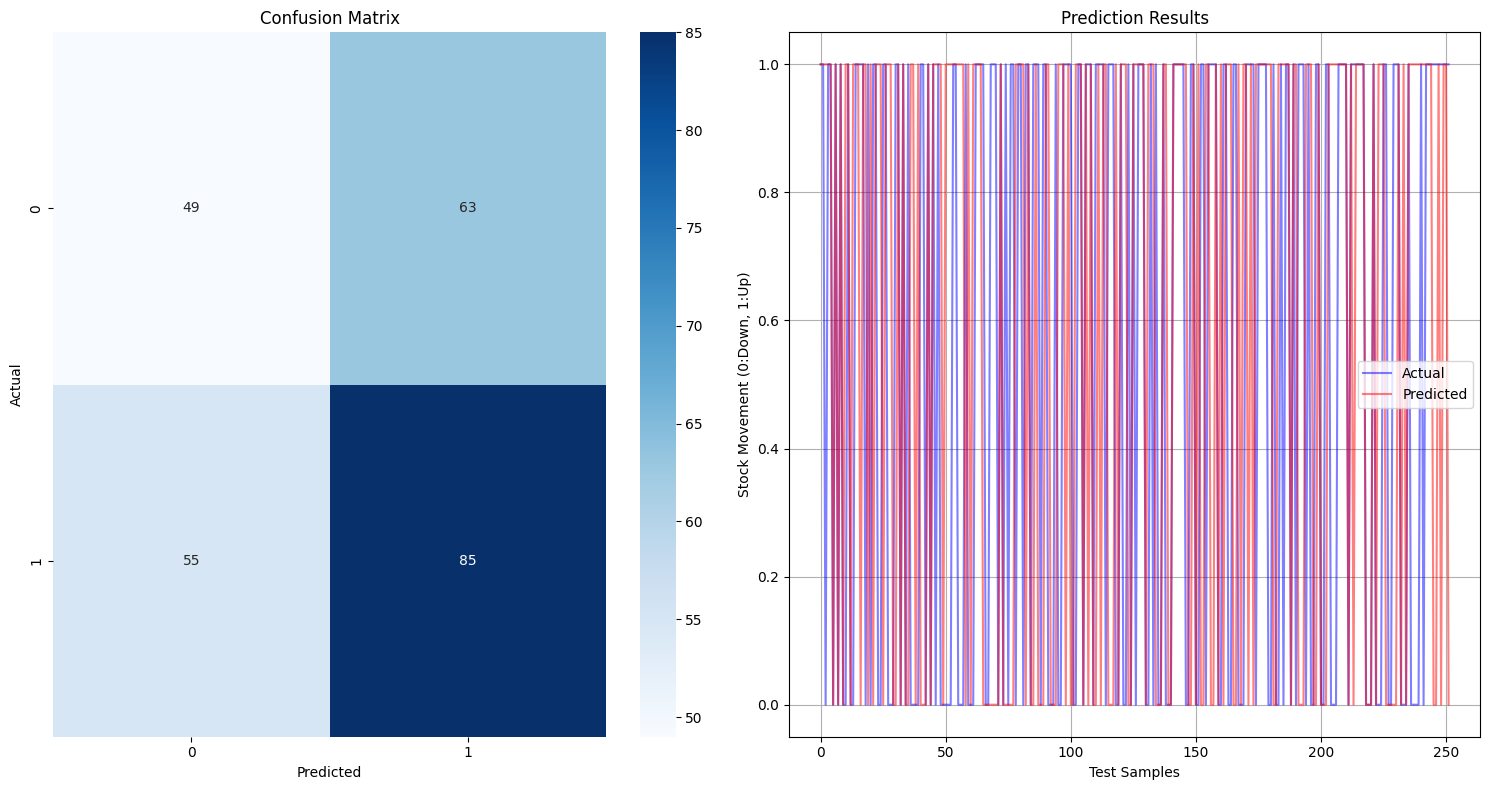


Overall Accuracy: 0.5317
Upward Movement Prediction Accuracy: 0.6071
Downward Movement Prediction Accuracy: 0.4375

Prediction Distribution:
1    0.587302
0    0.412698
Name: proportion, dtype: float64

Actual Distribution:
1    0.555556
0    0.444444
Name: proportion, dtype: float64


In [ ]:
# 第七個區塊：繪製結果
print("\n繪製預測結果...")
plot_prediction_results(predictions, true_labels, test_loader)
